In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import os, sys,glob, copy
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
import seaborn as sns



In [2]:
def condense_channel_matrix(tmp_X, df, case='between'):

    # combine units for each channel 
    new_matrix=np.zeros((len(depth_all), len(depth_all)))*np.NaN
    for i in range(len(depth_all)):
        for j in range(len(depth_all)):
            tmp_i = np.where((df.probe_id==new_probes[i]) & (df.channel_id==depth_all[i]))[0]
            tmp_j = np.where((df.probe_id==new_probes[j]) & (df.channel_id==depth_all[j]))[0]
            # removed within area
            if case=='between':
                if new_probes[i]!=new_probes[j]: 
                    if len(tmp_i)>1 or len(tmp_j)>1:
                        amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                    else:
                        amo = tmp_X[tmp_i, tmp_j]
                    new_matrix[i,j]=amo
            elif case=='within':
                if new_probes[i]==new_probes[j]: 
                    if len(tmp_i)>1 or len(tmp_j)>1:
                        amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                    else:
                        amo = tmp_X[tmp_i, tmp_j]
                    new_matrix[i,j]=amo
            elif case=='all':
                if len(tmp_i)>1 or len(tmp_j)>1:
                    amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                else:
                    amo = tmp_X[tmp_i, tmp_j]
                new_matrix[i,j]=amo
            else:
                print('case not specified!')
    return new_matrix

In [3]:
import networkx as nx
color_bank = {'probeA':'r',
                 'probeB':'brown',
                 'probeC': '#ff8c00',
                 'probeD': 'green',
                 'probeE': 'purple',
                 'probeF': 'blue'}

def plot_circle(t, r=1, center=[0,0]):
    x = r*np.cos(t) + center[0]
    y = r*np.sin(t) + center[1]
    return x, y

def set_nodes_position(df, depth_all, plot=False):  
    """
    set node location as function of channel id (depth)
    """
    n_nodes = len(depth_all)
    pos_probe={}
    pos_probe['probeC']=np.arange(250,310,0.6)/180.*np.pi
    pos_probe['probeD']=np.arange(180,240,0.6)/180.*np.pi
    pos_probe['probeE']=np.arange(120,180,0.6)/180.*np.pi
    pos_probe['probeF']=np.arange(60,120,0.6)/180.*np.pi
    pos_probe['probeA']=np.arange(0,60,0.6)/180.*np.pi
    pos_probe['probeB']=np.arange(310,360,0.4)/180.*np.pi


    probenames = df.probe_id.unique()
    t=[]
    for probe in probenames:
        chs = df[df.probe_id==probe].channel_id.unique()
        chs = chs-min(chs)
        if len(pos_probe[probe])>max(chs):
            t.append(pos_probe[probe][chs+1])
        else:
            print('Not enough nodes in '+probe+'. Add nodes!')
    t=np.concatenate(t, axis=0)
    print(len(t))

    pos={}
    for idx, a in enumerate(t):
        x, y = plot_circle(a)
        pos[idx]=np.array([x, y])

    if plot==True:
        FG = nx.Graph()
        # draw nodes
        for p in probenames:
            nx.draw_networkx_nodes(FG,pos,
                                   nodelist=list(probe_list[p]),
                                   node_color=color_bank[p],
                                   node_size=10,
                                   alpha=0.6)
        plt.axis('equal')

    # nodes id list for each probe
    probe_list={}
    for idx, probe in enumerate(probenames):
        probe_list[probe]=np.arange(n_nodes)[np.where(new_probes==probe)[0]]

    labels={}
    for i in range(n_nodes):
        labels[i]=int(depth_all[i])
    
    return pos, probe_list, labels

def set_nodes_position_within(df, probe, plot=False):  
    """
    set node location as function of channel id (depth) 
    clockwise s-m-d
    """

    pos_probe=np.arange(0-60, 360-60,4)/180.*np.pi

    chs = df[df.probe_id==probe].channel_id.unique()
    chs = chs-min(chs)
    if len(pos_probe)>max(chs):
        #t=np.concatenate([pos_probe[chs+1], [pos_probe[-1]]], axis=0)
        t=pos_probe[chs+1]
        
    else:
        print('Not enough nodes in '+probe+'. Add nodes!')

    pos={}
    for idx, a in enumerate(t):
        x, y = plot_circle(a)
        pos[idx]=np.array([x, y])

    if plot==True:
        FG = nx.Graph()
        # draw nodes
        nx.draw_networkx_nodes(FG, pos,
                               nodelist=range(len(t)),
                               node_color=color_bank[probe],
                               node_size=10,
                               alpha=0.6)
        plt.axis('equal')
    return pos

In [4]:
def inout_index(n_positive, n_negative):
    """
    compute index for connection going out of an source area or back to a source area
    """
    if n_positive+n_negative>0:
        return (n_positive-n_negative)/float(n_positive+n_negative)
    else:
        return np.NaN
    
def div_conv_degree(C, threshold=0.000001):
    """
    C: connectivity pattern for a given source neuron i to all neurons in the network
    threshold: threshold for significant connections
    """
    assert len(C)==len(df)
    
    N=len(C)
    index_div = np.where(C>threshold)[0]
    index_conv = np.where(C<-threshold)[0]
    
    return len(index_div)/float(N-1), len(index_conv)/float(N-1)



# compute for all mice

In [5]:
probes = ['probeC', 'probeF','probeD','probeE','probeB','probeA']

thresholds=[0, 0.0000001, 0.0000005, 0.000001, 0.000002, 0.000005] #0.000001

mouse_IDs = ['306046','388523', '389262','408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356', '416861','419112','419116'] #  

DIV_all=[]
CONV_all=[]
DF_all=[]

for threshold in thresholds:
    DIV=[]
    CONV=[]
    DF=[]
    print(threshold)
    for mouse_ID in mouse_IDs:
        #print(mouse_ID)
        # 1. load RF on screen matrix and meta
        X = np.load('~/data/Fig3/mouse'+mouse_ID+'_adjacency_matrix_RF.npy')
        df = pd.read_csv('~/data/Fig3/mouse'+mouse_ID+'_meta_cluster_RF.csv')

        assert len(df)==np.shape(X)[0]

        # sort acording to given areas
        new_index=[]
        new_areas=[]
        separations = [0]
        for a in probes:
            select_idx = np.where(df.probe_id.values==a)[0]
            if len(select_idx)>0:
                new_index.append(select_idx)
                separations = np.concatenate([separations, [separations[-1]+len(select_idx)]],axis=0)
            flat_list = [item for sublist in new_index for item in sublist]
        X_new = X[np.ix_(flat_list, flat_list)]
        df_new=df.iloc[[item for sublist in new_index for item in sublist]]

        N=np.shape(X_new)[0]

        div=np.zeros(N)
        conv=np.zeros(N)
        for i in range(N):
            Ci = X_new[i,:]
            d, c = div_conv_degree(Ci, threshold=threshold)
            div[i]=d
            conv[i]=c
        df_new['div']=div
        df_new['conv']=conv

        DF.append(df_new)
        DIV.append(div)
        CONV.append(conv)
    
        #plt.figure(figsize=(10,3))
        #plt.plot(div, label='divergence degree')
        #plt.plot(conv, label='convergence degree')
        #plt.legend()
        #plt.ylim([0,0.7])

    DIV = [item for sublist in DIV for item in sublist]
    CONV = [item for sublist in CONV for item in sublist]
    DF=pd.concat(DF, axis=0)
    DF = DF.reset_index().drop(['index'], axis=1)
    
    DIV_all.append(DIV)
    CONV_all.append(CONV)
    DF_all.append(DF)


0
1e-07
5e-07
1e-06
2e-06
5e-06


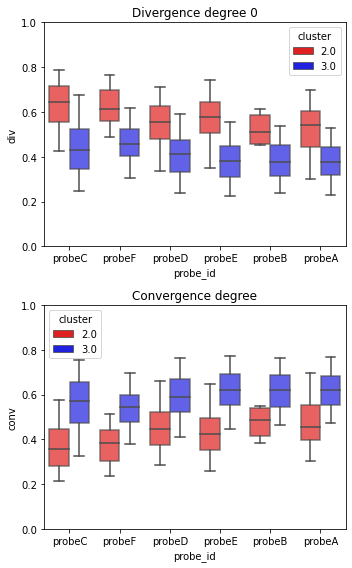

In [6]:
idx=0
DF = DF_all[idx]

plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
cplate=['red','blue']
ax = sns.boxplot(x = 'probe_id',y='div',
            hue="cluster", 
            order = ['probeC', 'probeF','probeD','probeE','probeB','probeA'],
            palette=cplate,
            boxprops=dict(alpha=.7),
            whis=[5, 95],
            data=DF[DF.cluster!=1],
            showfliers = False)
ax.set_ylim([0,1])
plt.title('Divergence degree '+str(thresholds[idx]))

plt.subplot(2,1,2)
ax = sns.boxplot(x = 'probe_id',y='conv',
            hue="cluster", 
            order = ['probeC', 'probeF','probeD','probeE','probeB','probeA'],
            palette=cplate,
            boxprops=dict(alpha=.7),
            whis=[5, 95],
            data=DF[DF.cluster!=1],
            showfliers = False)
plt.title('Convergence degree')
ax.set_ylim([0,1])
plt.tight_layout()


In [7]:
tmp1 = DF[(DF.cluster==2) & (DF.probe_id=='probeC')]['div'].values
tmp2 = DF[(DF.cluster==2) & (DF.probe_id=='probeA')]['div'].values

In [8]:
np.nanmean(tmp1), np.nanstd(tmp1)/np.sqrt(len(tmp1))

(0.6290175984402011, 0.004594871465250685)

In [9]:
np.nanmean(tmp2), np.nanstd(tmp2)/np.sqrt(len(tmp2))

(0.5186961558155261, 0.019072533792914605)

In [11]:
from scipy.stats import ttest_ind
ttest_ind(tmp1, tmp2)

Ttest_indResult(statistic=6.220158483385907, pvalue=8.751683760962416e-10)

In [12]:
from scipy.stats import ranksums
ranksums(tmp1, tmp2)

RanksumsResult(statistic=5.421805539721893, pvalue=5.9000045673596324e-08)

In [ ]:
# use 2-Way anova to test whether divergence is consistently higher in driver than driven across areas

R-squared: 0.700382
$r_P$ = -0.84; $P_P$ = 0.037738
$r_S$ = -0.94; $P_S$ = 0.004805
R-squared: 0.551235
$r_P$ = -0.74; $P_P$ = 0.090955
$r_S$ = -0.94; $P_S$ = 0.004805


Text(0.5, 0, 'Anatomical hierarchy score')

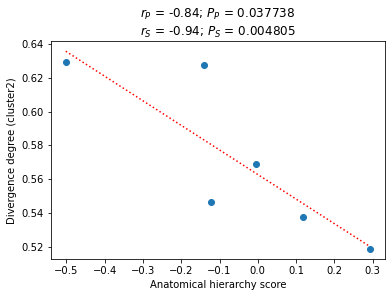

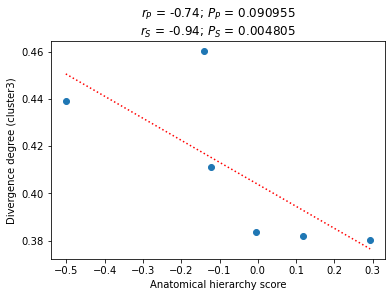

In [14]:
HS = [-0.50149, -0.13929, -0.12294, -0.00431, 0.11828, 0.29330] # CC-CT-TC global HS from Harris

from scipy.stats import linregress, pearsonr, spearmanr

#idx=0
#DF = DF_all[idx]
means_frank = []
for p in ['probeC', 'probeF','probeD','probeE','probeB','probeA']:
    means_frank.append(np.mean(DF[(DF.probe_id==p) & (DF.cluster==2)]['div'].values))

plt.figure()
plt.scatter(HS, means_frank )
res = linregress(HS, means_frank)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(HS, res.intercept + res.slope*np.array(HS), ':r', label='fitted line')

r_s,p_s = spearmanr(HS, means_frank)
r_p,p_p = pearsonr(HS, means_frank)
print('$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,6)) + '\n' + \
            '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,6)))
plt.title('$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,6)) + '\n' + \
            '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,6)))
plt.ylabel('Divergence degree (cluster2)')
plt.xlabel('Anatomical hierarchy score')


means_frank = []
# Spearman's correlation with each area's HS from Harris paper (global hierarchy score)
for p in ['probeC', 'probeF','probeD','probeE','probeB','probeA']:
    means_frank.append(np.mean(DF[(DF.probe_id==p) & (DF.cluster==3)]['div'].values))

plt.figure()
plt.scatter(HS, means_frank )
res = linregress(HS, means_frank)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(HS, res.intercept + res.slope*np.array(HS), ':r', label='fitted line')

r_s,p_s = spearmanr(HS, means_frank)
r_p,p_p = pearsonr(HS, means_frank)
print('$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,6)) + '\n' + \
            '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,6)))
plt.title('$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,6)) + '\n' + \
            '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,6)))
plt.ylabel('Divergence degree (cluster3)')
plt.xlabel('Anatomical hierarchy score')



In [ ]:
# shuffle control

306046
388523
389262
408153
410344
415149
412809
412804
416856
419114
419117
419118
419119
424445
415148
416356
416861
419112
419116


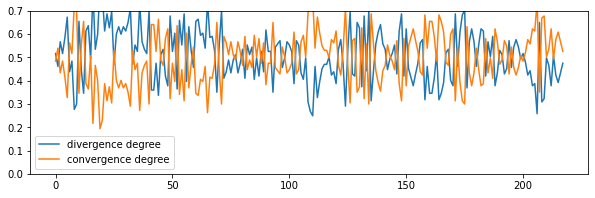

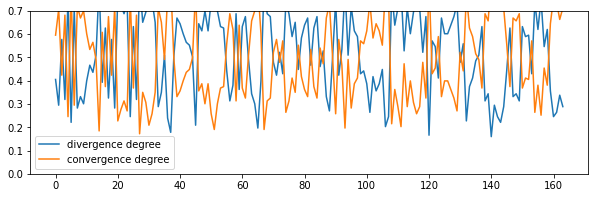

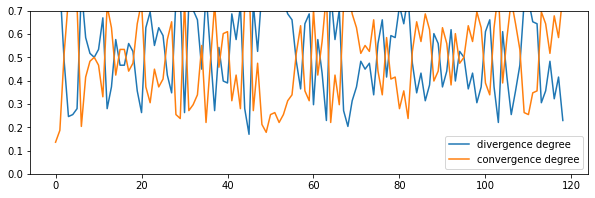

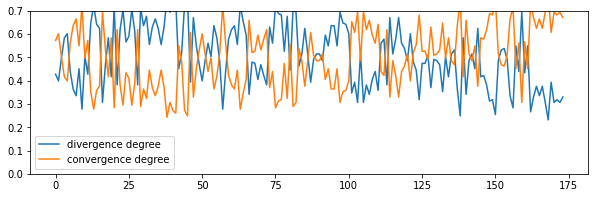

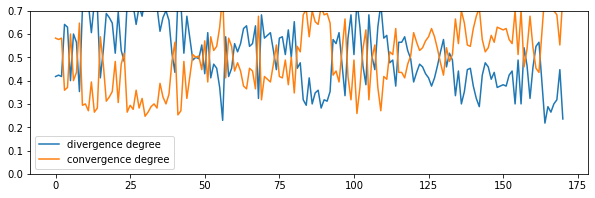

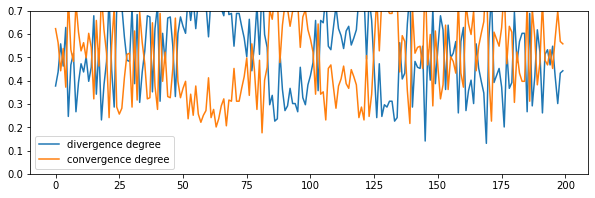

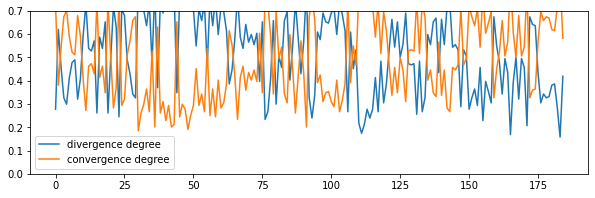

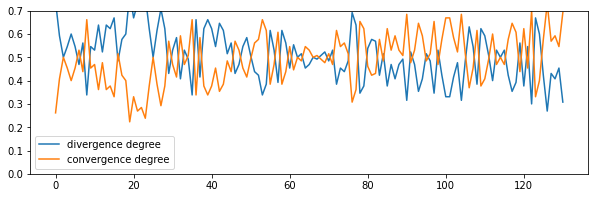

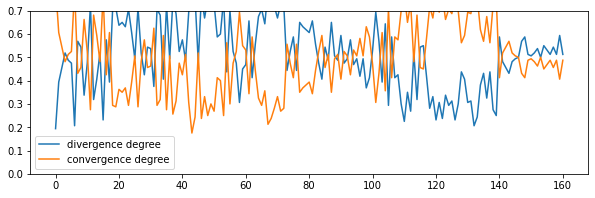

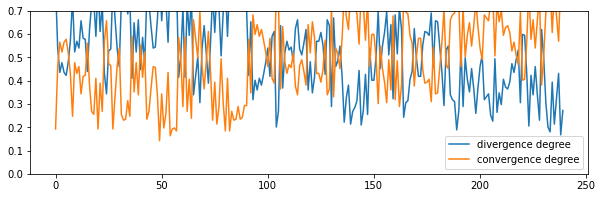

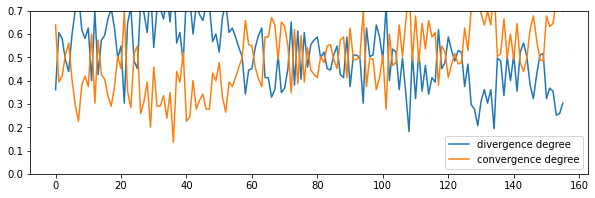

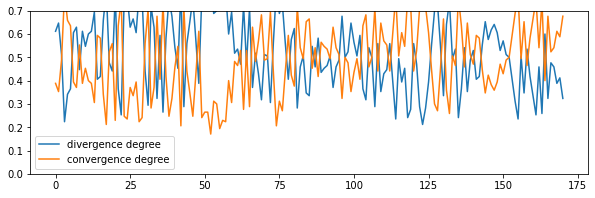

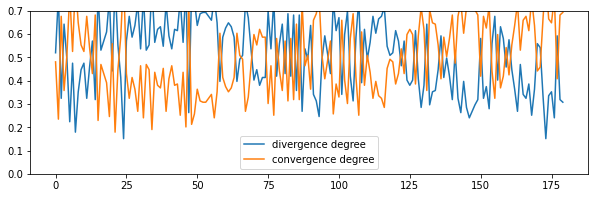

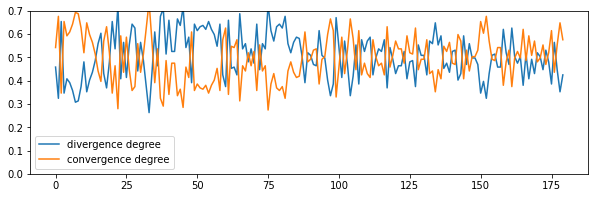

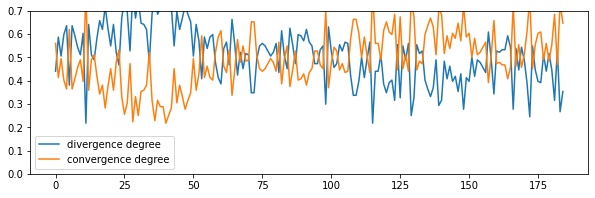

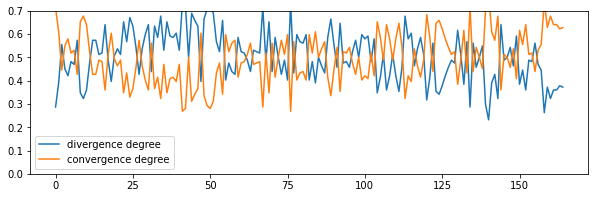

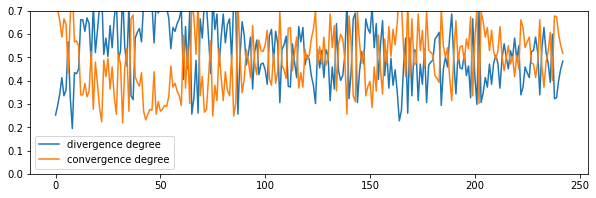

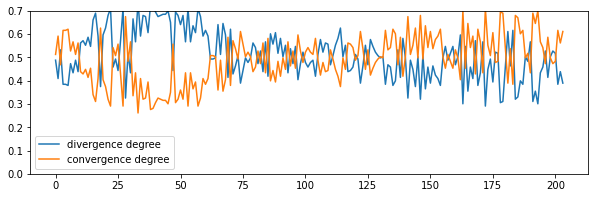

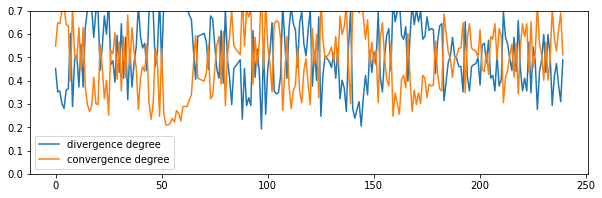

In [16]:
import random
probes = ['probeC', 'probeF','probeD','probeE','probeB','probeA']

threshold=0.000001 #0.000001
threshold=0

mouse_IDs = ['306046','388523', '389262','408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356', '416861','419112','419116'] #  

DIV=[]
CONV=[]
DF=[]
for mouse_ID in mouse_IDs:
    print(mouse_ID)
    # 1. load RF on screen matrix and meta
    X = np.load('~/data/Fig3/mouse'+mouse_ID+'_adjacency_matrix_RF.npy')
    df = pd.read_csv('~/data/Fig3/mouse'+mouse_ID+'_meta_cluster_RF.csv')

    # 2. load full matrix with FR>2 (N is dominanted by weak connections)
    #X = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/adjacency_matrix/mouse'+mouse_ID+'_adjacency_matrix.npy')
    #df = pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/adjacency_matrix/mouse'+mouse_ID+'_adjacency_matrix.csv')

    #from denoise_matrix import denoise_matrix
    #X, k, threshold = denoise_matrix(X, threshold=0.95, plot=True)
        
        
    assert len(df)==np.shape(X)[0]
    
    # sort acording to given areas
    new_index=[]
    new_areas=[]
    separations = [0]
    for a in probes:
        select_idx = np.where(df.probe_id.values==a)[0]
        if len(select_idx)>0:
            new_index.append(select_idx)
            separations = np.concatenate([separations, [separations[-1]+len(select_idx)]],axis=0)
        flat_list = [item for sublist in new_index for item in sublist]
    X_new = X[np.ix_(flat_list, flat_list)]
    df_new=df.iloc[[item for sublist in new_index for item in sublist]]

    N=np.shape(X_new)[0]
    
    div=np.zeros(N)
    conv=np.zeros(N)
    for i in range(N):
        Ci = X_new[i,:]
        d, c = div_conv_degree(Ci, threshold=threshold)
        div[i]=d
        conv[i]=c
    df_new['div']=div
    df_new['conv']=conv
    
    # shuffle area labels
    probe_ids = df_new.probe_id.values
    random.shuffle(probe_ids)
    df_new['probe_id']=probe_ids
    
    DF.append(df_new)
    DIV.append(div)
    CONV.append(conv)
    
    plt.figure(figsize=(10,3))
    plt.plot(div, label='divergence degree')
    plt.plot(conv, label='convergence degree')
    plt.legend()
    plt.ylim([0,0.7])
        
DIV = [item for sublist in DIV for item in sublist]
CONV = [item for sublist in CONV for item in sublist]
DF=pd.concat(DF, axis=0)
DF = DF.reset_index().drop(['index'], axis=1)

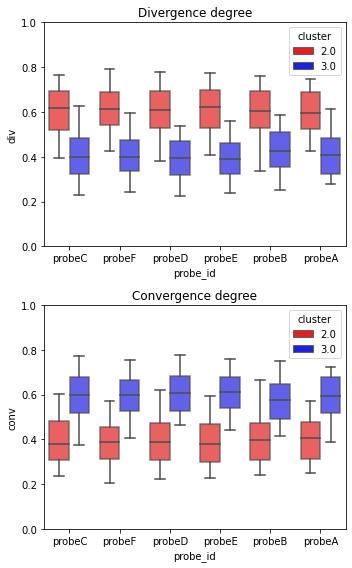

In [17]:
plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
cplate=['red','blue']
ax = sns.boxplot(x = 'probe_id',y='div',
            hue="cluster", 
            order = ['probeC', 'probeF','probeD','probeE','probeB','probeA'],
            palette=cplate,
            boxprops=dict(alpha=.7),
            whis=[5, 95],
            data=DF[DF.cluster!=1],
            showfliers = False)
ax.set_ylim([0,1])
plt.title('Divergence degree')

plt.subplot(2,1,2)
ax = sns.boxplot(x = 'probe_id',y='conv',
            hue="cluster", 
            order = ['probeC', 'probeF','probeD','probeE','probeB','probeA'],
            palette=cplate,
            boxprops=dict(alpha=.7),
            whis=[5, 95],
            data=DF[DF.cluster!=1],
            showfliers = False)
plt.title('Convergence degree')
ax.set_ylim([0,1])
plt.tight_layout()
